In [26]:
import numpy as np

def norm(arr):
    max = np.amax(arr)
    for i in arr:
        for j in range(len(i)):
            i[j] = i[j]/max
    return np.array(arr)

def avg_var(arr):
    num = 0
    sum = 0
    sum_2 = 0
    x = 0
    y = 0
    for i in arr:
        for j in i:
            sum += j
            sum_2 += j*j
            num += 1
    avg = sum/num
    var = sum_2/num - avg*avg
    return avg, var

test = [[1,2,3,4,5],[6,7,8,9,10]]
avg ,var = avg_var(test)

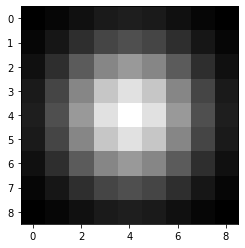

In [27]:
# read PSF
testcase = 'crema.list'
import matplotlib.pyplot as plt

psf = np.load('2dGaussian.npy')
plt.imshow(psf, cmap='gray')
plt.show()


# grad = signal.convolve2d(ascent, scharr, boundary='symm', mode='same')

# import matplotlib.pyplot as plt

# fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))

# ax_orig.imshow(ascent, cmap='gray')

# ax_orig.set_title('Original')

# ax_orig.set_axis_off()

# ax_mag.imshow(np.absolute(grad), cmap='gray')

# ax_mag.set_title('Gradient magnitude')

# ax_mag.set_axis_off()

# ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles

# ax_ang.set_title('Gradient orientation')

# ax_ang.set_axis_off()

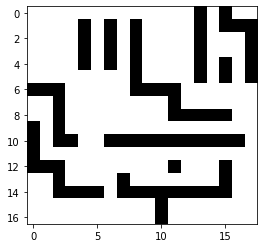

In [28]:
# see whole pattern
import pickle

with open('testcase/'+testcase, 'rb') as filehandle:
    testcase = pickle.load(filehandle)
x = testcase[0][1]
y = testcase[0][0]

plane = np.zeros(shape=(x,y))
for i in range(x):
    for j in range(y):
        plane[i][j] = 1

for g in range(1,len(testcase)):
    group = testcase[g]
    for i in group:
        for j in i:
            for k in j:
                plane[k[1]][k[0]] = 0

plt.imshow(plane, cmap='gray')
plt.show()

In [29]:
from scipy import signal
import copy
import pandas as pd

result = []
mask = [] # mask0, flare0, mask1, flare1

def computeFlare(dis):
    if len(dis) < (len(testcase)-1):
        a = copy.deepcopy(dis)
        a.append(True)
        b = copy.deepcopy(dis)
        b.append(False)
        computeFlare(a)
        computeFlare(b)
    else:
        mask0 = np.zeros(shape=(x,y))
        mask1 = np.zeros(shape=(x,y))
        grid0 = 0
        grid1 = 0
        pat0 = 0
        pat1 = 0
        for i in range(x):
            for j in range(y):
                mask0[i][j] = 1
                mask1[i][j] = 1

        for g in range(1,len(testcase)):
            group = testcase[g]
            if dis[g-1] == True:
                w = group[0]
                b = group[1]
            else:
                b = group[0]
                w = group[1]
            for j in w:
                pat0 += 1
                for k in j:
                    mask0[k[1]][k[0]] = 0
                    grid0 += 1
            for j in b:
                pat1 += 1
                for k in j:
                    mask1[k[1]][k[0]] = 0
                    grid1 += 1

        flare0 = signal.convolve2d(mask0, psf, boundary='symm', mode='same')
        avg0, var0 = avg_var(flare0)
        flare1 = signal.convolve2d(mask1, psf, boundary='symm', mode='same')
        avg1, var1 = avg_var(flare1)
        temp = [avg0, var0, grid0, avg1, var1, grid1, (var0+var1)/2, abs(var0-var1)]
        result.append(temp)
        temp = [mask0, flare0, mask1, flare1]
        mask.append(temp)

def FlareAll():
    computeFlare([True])
    computeFlare([False])
    
FlareAll()

df = pd.DataFrame(result, columns=['avg0', 'var0', 'grid0', 'avg1', 'var1', 'grid1', 'var', 'var_diff'])

df

,avg0,var0,grid0,avg1,var1,grid1,var,var_diff
0,20.854664,2.878324,40,20.541060,4.315402,44,3.596863,1.437078
1,20.384258,3.252855,46,21.011466,2.901054,38,3.076954,0.351800
2,20.697862,3.797356,42,20.697862,2.779665,42,3.288510,1.017691
3,20.227456,4.875314,48,21.168268,2.068745,36,3.472030,2.806569
4,20.776263,2.410733,41,20.619461,3.662742,43,3.036738,1.252009
5,20.305857,3.622752,47,21.089867,3.085883,37,3.354317,0.536869
6,20.619461,3.305178,43,20.776263,2.102417,41,2.703798,1.202760
7,20.149055,5.220625,49,21.246669,2.228987,35,3.724806,2.991638
8,21.481872,1.940543,32,19.913852,4.376637,52,3.158590,2.436094
9,21.011466,2.520271,38,20.384258,3.167487,46,2.843879,0.647216


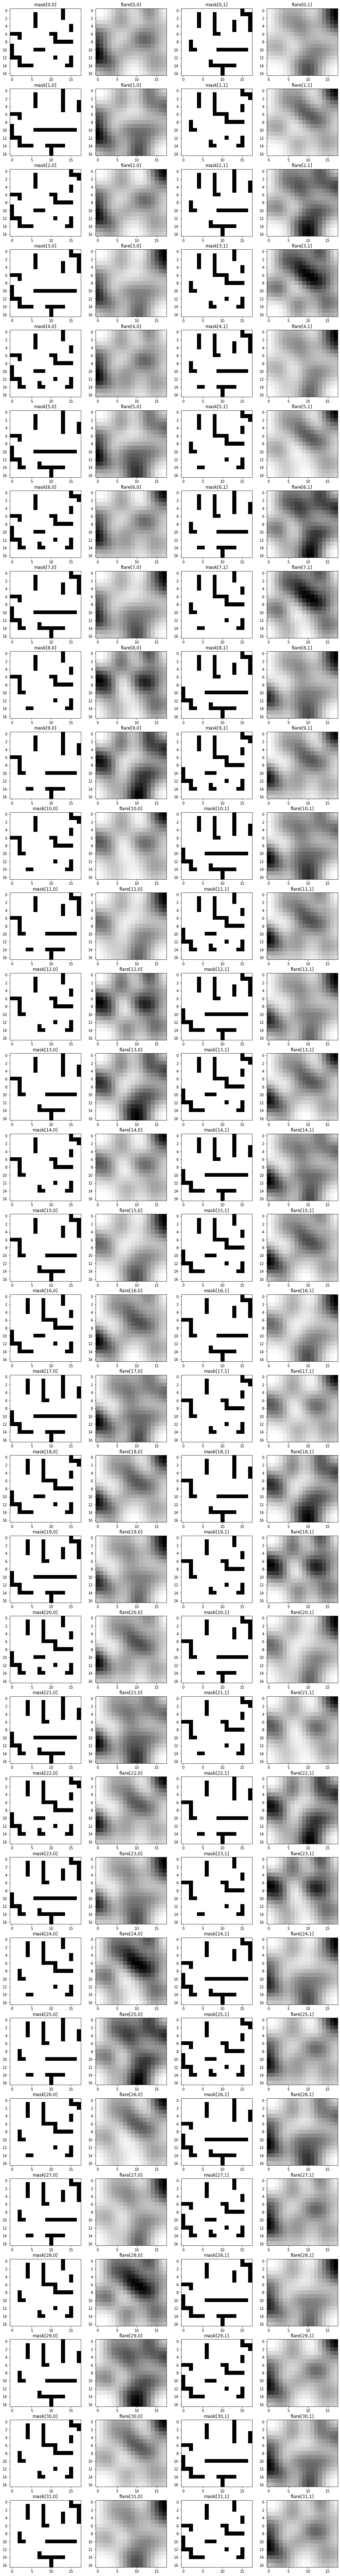

In [30]:
comb = pow(2,len(testcase)-1)
fig, f = plt.subplots(comb,4,figsize=(16,comb*4))
for i in range(comb):
    f[i, 0].imshow(mask[i][0], cmap='gray')
    f[i, 0].set_title('mask[' + str(i) + ',0]')
    f[i, 1].imshow(mask[i][1], cmap='gray')
    f[i, 1].set_title('flare[' + str(i) + ',0]')
    f[i, 2].imshow(mask[i][2], cmap='gray')
    f[i, 2].set_title('mask[' + str(i) + ',1]')
    f[i, 3].imshow(mask[i][3], cmap='gray')
    f[i, 3].set_title('flare[' + str(i) + ',1]')